# Exploratory Data Analysis (EDA)

## Imports

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## 1. Load Data

From last week you should have the following data in your local directory:
```
- data/gene_match_data.csv
- data/amr_data.csv
- data/e_coli_summary_data.csv
```

If not, please raise your hand and we can pause to make sure everyone has the data ready to go

In [2]:
def load_data():
    """
    Load the data needed for Workshop 3
    """
    gene_alignment_df = pd.read_csv(r"C:\Users\gangu\Downloads\gene_match_data (1).csv")
    gene_alignment_df = gene_alignment_df.rename(columns={'ref_name':'genome_id'}).drop(columns=['Unnamed: 0'])
    amr_df = pd.read_csv(r'C:\Users\gangu\Downloads\amr_data (1).csv').drop(columns=['Unnamed: 0'])
    genome_summary_df = pd.read_csv(r'C:\Users\gangu\Downloads\e_coli_summary_data (1).csv').drop(columns=['Unnamed: 0'])

    # Subset IDS
    genome_summary_df = genome_summary_df[genome_summary_df.genome_id.isin(gene_alignment_df.genome_id.unique())]
    amr_df = amr_df[amr_df.genome_id.isin(gene_alignment_df.genome_id.unique())]
    
    return gene_alignment_df, amr_df, genome_summary_df

gene_alignment_df, amr_df, genome_summary_df = load_data()

## 2. Summarize and Review Data

Lets first take a look through the data we're using and recap what the important elements are

### 2a. Take a glance at the data itself

In [3]:
# Review the top three rows of each dataset
print("Gene Alignment Data (Top 3 Rows):")
print(gene_alignment_df.head(3))

print("\nAMR Data (Top 3 Rows):")
print(amr_df.head(3))

print("\nGenome Summary Data (Top 3 Rows):")
print(genome_summary_df.head(3))

Gene Alignment Data (Top 3 Rows):
   genome_id        contig                                           res_gene  \
0  562.11346  FLKS01000064  gb|U00096.3|-|3324062-3324911|ARO:3003386|Ecol...   
1  562.11346  FLKS01000044  gb|AP009048.1|+|3760295-3762710|ARO:3003303|Ec...   
2  562.11346  FLKS01000070  gb|BA000007.3|+|4990267-4994296|ARO:3003288|Ec...   

   match_start  match_end match_qual  \
0        96835      97684       849M   
1        61096      63511      2415M   
2        22038      26067      4029M   

                                           query_str  \
0  ATGAAACTCTTTGCCCAGGGTACTTCACTGGACCTTAGCCATCCTC...   
1  ATGTCGAATTCTTATGACTCCTCCAGTATCAAAGTCCTGAAAGGGC...   
2  TTACTCGTCTTCCAGTTCGATGTTGATACCCAGCGAACGAATCTCT...   

                                        ref_gene_str  
0  ATGAAACTCTTTGCCCAGGGTACTTCACTGGACCTTAGCCATCCTC...  
1  ATGTCGAATTCTTATGACTCCTCCAGTATCAAAGTCCTGAAAGGGC...  
2  TTACTCGTCTTCCAGTTCGATGTTGATACCCAGCGAACGAATCTCT...  

AMR Data (Top 3 Rows):
   genome_i

In [4]:
# Take a look at the fields for the AMR and genome datasets
amr_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 974 entries, 1 to 1081
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   genome_id                         974 non-null    float64
 1   genome_name                       974 non-null    object 
 2   taxon_id                          974 non-null    float64
 3   antibiotic                        974 non-null    object 
 4   resistant_phenotype               974 non-null    object 
 5   measurement                       288 non-null    object 
 6   measurement_sign                  288 non-null    object 
 7   measurement_value                 288 non-null    float64
 8   measurement_unit                  288 non-null    object 
 9   laboratory_typing_method          408 non-null    object 
 10  laboratory_typing_method_version  0 non-null      float64
 11  laboratory_typing_platform        693 non-null    object 
 12  vendor      

In [5]:
genome_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 973 entries, 0 to 1079
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   genome_id                   973 non-null    float64
 1   genome_name                 973 non-null    object 
 2   taxon_id                    973 non-null    int64  
 3   genome_status               971 non-null    object 
 4   genome_length               973 non-null    int64  
 5   gc_content                  971 non-null    float64
 6   contig_l50                  971 non-null    float64
 7   contig_n50                  971 non-null    float64
 8   chromosomes                 134 non-null    float64
 9   plasmids                    134 non-null    float64
 10  contigs                     973 non-null    int64  
 11  patric_cds                  973 non-null    float64
 12  refseq_cds                  306 non-null    float64
 13  trna                        971 non-nul

The data summary reveals significant sparsity in several columns, such as chromosomes, plasmids, and particularly rrnacoarse_consistency, which contains no non-null values. At the same time, core fields like genome_id, genome_name, and genome_length are fully populated, while genome quality metrics like checkm_completeness and checkm_contamination are only partially complete, highlighting variability in data availability across different attributes.

Missingness in many columns!

Dtypes are important to review - e.g. our genome IDs are being interpreted as floats - does that make sense?

### 3. Clean Data & Check Quality

Now we have a basic understanding of the format and shape of the data, the next step is to take a look at any issues with data quality and ensure we have a clean dataset to start modeling.

The best way to divide this out is to first look at our targets and then our training data

### 3a. What Targets can we use?

Lets start with the AMR data - we know there is no missing data here so what targets do we have to work with?

In [6]:
# Summary the counts of each unique value in the AMR data "resistant_phenotype"
amr_df['resistant_phenotype'].value_counts()

resistant_phenotype
Susceptible                   781
Resistant                     139
Intermediate                   53
Susceptible-dose dependent      1
Name: count, dtype: int64

In [7]:
# We're going to be making this task binary for simplicity
resistant_to_ris = {
    'Susceptible':'S', 
    'Susceptible-dose dependent':'R', 
    'Intermediate':'R', 
    'Resistant':'R'
}
amr_df['target'] = amr_df['resistant_phenotype'].apply(lambda x: resistant_to_ris.get(x))

Text(0.5, 1.0, 'Count of Target Classes')

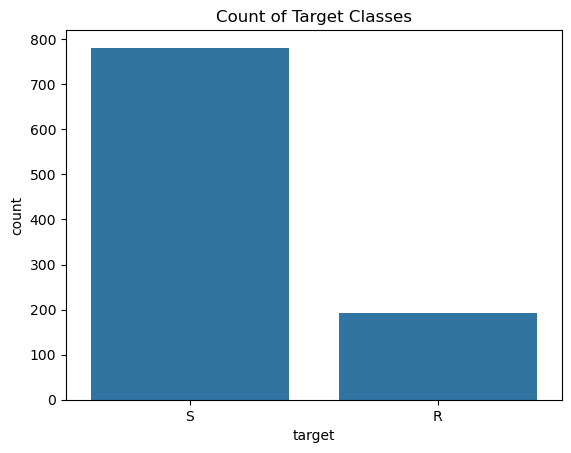

In [8]:
# Make a bar plot of our targets (hint: seaborn has nice formatting for this)
g = sns.barplot(amr_df.target.value_counts())
g.set_title("Count of Target Classes")

Imbalanced data can lead to biased models that favor the majority class, resulting in poor performance for the minority class, which is often the one of greater interest in fields like healthcare or fraud detection. This bias can skew evaluation metrics, such as accuracy, making them misleading and masking the model's ineffectiveness in correctly predicting the minority instances. Furthermore, imbalanced datasets can hinder the model's ability to generalize, leading to overfitting on the dominant class while neglecting the unique characteristics of the minority class.

### 3b. What is the quality level of our Genomes?

Now we've assessed and cleaned the target data, lets have a look at the genome quality. How can we even go about assessing genome quality without being a genomics expert?

We can look for outliers!

One thing to note about reviewing outliers is:
- NEVER remove data just by virtue of being an outlier
- Outliers could be junk data but they could also be representing something really unique and important
- Always consult with an expert to assess whether an outlier can be removed

In [9]:
# Lets look at our data again
genome_summary_df.columns

Index(['genome_id', 'genome_name', 'taxon_id', 'genome_status',
       'genome_length', 'gc_content', 'contig_l50', 'contig_n50',
       'chromosomes', 'plasmids', 'contigs', 'patric_cds', 'refseq_cds',
       'trna', 'rrnacoarse_consistency', 'fine_consistency',
       'checkm_completeness', 'checkm_contamination',
       'genome_qualitydate_created', 'date_modified'],
      dtype='object')

Useful data to review:
- gc_content (proportion of the genome nucleotides that are G or C)
- contig_l50 / n50 (size and shape of contigs within our assembly)
- checkm completeness (assessment of how complete the genome is)

Unfortunately we're missing data for a lot of CheckM so we shouldn't rely on it! This is why it's useful to review the data manually first

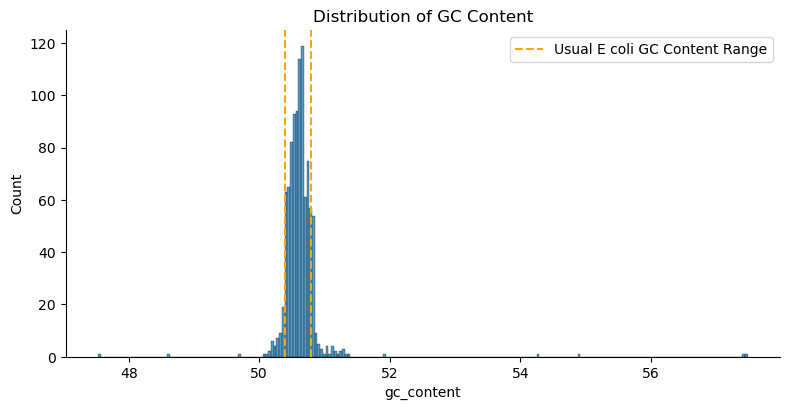

In [10]:
# View the distribution of gc_content across our data
# From a search on google, Escherichia coli should have a GC content around 50.4-50.8%
g = sns.displot(genome_summary_df.gc_content, height=4, aspect=2)
g.axes[0][0].axvline(50.4, ls='--', c='orange', label='Usual E coli GC Content Range')
g.axes[0][0].axvline(50.8, ls='--', c='orange')
g.axes[0][0].legend()
g.set(title='Distribution of GC Content');

The graph depicts that the E.coli contains gc content in the range of 50.4 and 50.8.

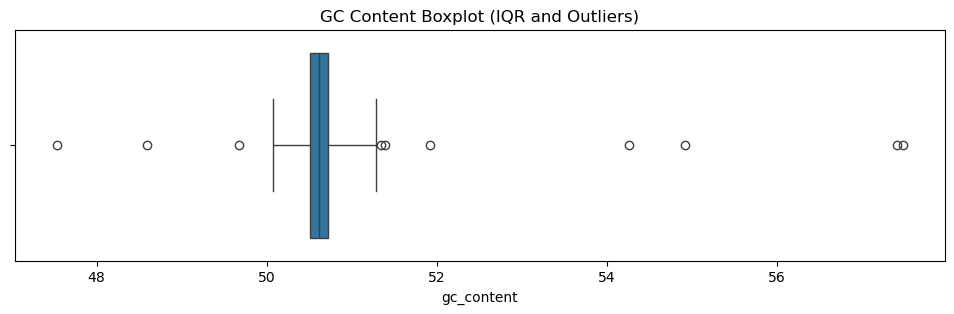

In [11]:
# Which genomes should we consider outliers?
fig, ax = plt.subplots(1, 1, figsize=(12,3))
sns.boxplot(genome_summary_df.gc_content, orient='h', ax=ax, whis=3.0)
ax.set_title('GC Content Boxplot (IQR and Outliers)');

The above boxplot automatically calculates outliers (circles) based on the IQR (the default is 1.5)

This is based on having a normal distribution.

In [12]:
# Lets take a look at anything beyond the upper/lower quartiles +/- (IQR * 3.0) to be conservative
lower_quartile, upper_quartile = genome_summary_df.gc_content.dropna().quantile([0.25, 0.75])
iqr = scipy.stats.iqr(genome_summary_df.gc_content.dropna())
upper_limit = upper_quartile + (iqr * 3)
lower_limit = lower_quartile - (iqr * 3)

outliers_data = genome_summary_df[
  (genome_summary_df['gc_content'] < lower_limit) |
(genome_summary_df['gc_content']> upper_limit)
]
print(outliers_data)
outliers_data.shape

      genome_id                        genome_name  taxon_id genome_status  \
529   562.42709        Escherichia coli strain 287       562           WGS   
688   562.77360     Escherichia coli strain 703273       562      Complete   
886   562.12961  Escherichia coli strain F1-8-ERB4       562           WGS   
956   562.42818         Escherichia coli strain M8       562           WGS   
995   562.42857  Escherichia coli strain MUGSI_274       562           WGS   
1012  562.12962      Escherichia coli strain PB486       562           WGS   
1013  562.58621      Escherichia coli strain PH100       562           WGS   
1016  562.58624      Escherichia coli strain PH108       562           WGS   
1026  562.58634       Escherichia coli strain PH20       562           WGS   
1078  562.58645       Escherichia coli strain WU44       562           WGS   

      genome_length  gc_content  contig_l50  contig_n50  chromosomes  \
529        10639957   54.266815        17.0    191252.0          NaN 

(10, 20)

At this point we could remove these samples or we can keep them.

If in doubt it's generally better to keep them and check later if they seem to be having an impact

## 4. Visualize Key Data Features

Now that we have a good assessment of our data quality - lets move on to understanding our potential modeling features.

This is where we want to start assessing the gene alignments we made last week

In [13]:
# Lets take a quick look at the data to refresh out memories again
n_unique_samples = len(gene_alignment_df.genome_id.unique())
n_unique_genes = len(gene_alignment_df.res_gene.unique())

print(f'Shape of data: {gene_alignment_df.shape}')
print(f'\nN unique samples: {n_unique_samples}')
print(f'\nN unique genes: {n_unique_genes}\n')
display(gene_alignment_df.head(3))

Shape of data: (247853, 8)

N unique samples: 973

N unique genes: 1510



,genome_id,contig,res_gene,match_start,match_end,match_qual,query_str,ref_gene_str
0,562.11346,FLKS01000064,gb|U00096.3|-|3324062-3324911|ARO:3003386|Ecol...,96835,97684,849M,ATGAAACTCTTTGCCCAGGGTACTTCACTGGACCTTAGCCATCCTC...,ATGAAACTCTTTGCCCAGGGTACTTCACTGGACCTTAGCCATCCTC...
1,562.11346,FLKS01000044,gb|AP009048.1|+|3760295-3762710|ARO:3003303|Ec...,61096,63511,2415M,ATGTCGAATTCTTATGACTCCTCCAGTATCAAAGTCCTGAAAGGGC...,ATGTCGAATTCTTATGACTCCTCCAGTATCAAAGTCCTGAAAGGGC...
2,562.11346,FLKS01000070,gb|BA000007.3|+|4990267-4994296|ARO:3003288|Ec...,22038,26067,4029M,TTACTCGTCTTCCAGTTCGATGTTGATACCCAGCGAACGAATCTCT...,TTACTCGTCTTCCAGTTCGATGTTGATACCCAGCGAACGAATCTCT...


### 4a. Visualize Genes Counts

Given the above data we have 1,502 genes which are either present or absent in each of our 773 unique samples based on the alignment. Lets take one random gene and see how it looks

In [14]:
# Select a gene at "random"
random_gene = 'gb|EU274580.1|+|214-1075|ARO:3001030|TEM-164'

We can look up this gene on CARD's website: https://card.mcmaster.ca/ontology/37410

**TEM-164** is an extended-spectrum beta-lactamase found in Klebsiella pneumoniae


In [15]:
# Lets see how often it appears across our dataset
n_samples_gene_present = len(gene_alignment_df[gene_alignment_df['res_gene'].isin([random_gene])])
n_samples_gene_absent = n_unique_samples - n_samples_gene_present

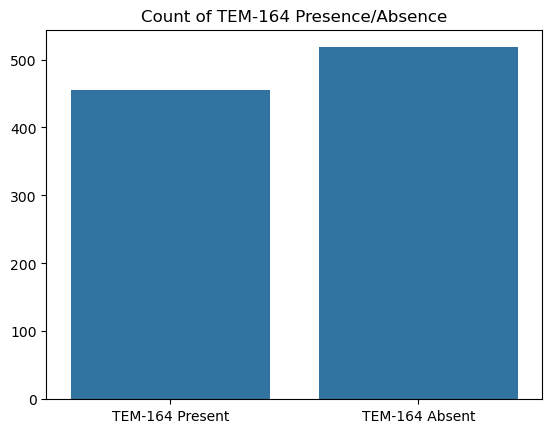

In [16]:
g = sns.barplot(
    x=['TEM-164 Present', 'TEM-164 Absent'], 
    y=[n_samples_gene_present, n_samples_gene_absent]
)
g.set_title("Count of TEM-164 Presence/Absence");

Around 200 resistant samples are present. it appears that there are roughly equal counts for TEM-164 Present and TEM-164 Absent. 

That's for just a single gene though - what does this look like across genes?

In [17]:
# First lets make a dataframe with genome_id x res_gene with 1 for present and 0 for absent
gene_presence_absence = (
    gene_alignment_df
    [['genome_id', 'res_gene']]
    .assign(count = 1)
    .pivot_table('count', index='genome_id', columns="res_gene")
    .fillna(0)
) 

In [18]:
# Take a look at this
gene_presence_absence.iloc[0:4, 0:4]

res_gene,gb|AAAGNS010000063.1|-|144-1005|ARO:3000966|TEM-103,gb|AB023477.1|+|0-861|ARO:3001082|SHV-24,gb|AB039845.1|+|25-1945|ARO:3000186|tet(M),gb|AB049569.1|+|0-861|ARO:3000958|TEM-91
genome_id,,,,
562.11346,0.0,0.0,0.0,0.0
562.11347,1.0,0.0,0.0,1.0
562.11349,1.0,0.0,0.0,1.0
562.11557,0.0,0.0,0.0,0.0


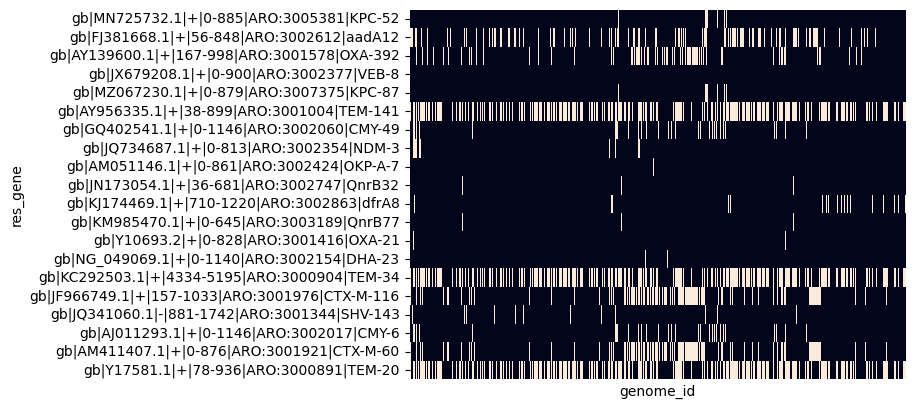

In [19]:
# Visualize the across a random sample of 20 genes
sns.heatmap(
    gene_presence_absence.transpose().sample(20, random_state=130), 
    xticklabels=False,
    cbar=False,
);

The visualization presents a list of resistant genes associated with various genome IDs, indicating the presence of multiple resistance genes across different genomes. Each entry features a genome identifier, a directional indicator, a range of base pairs, and the corresponding resistance gene annotation, allowing for a quick assessment of resistance across samples. However, the visualization lacks details on the functionality of each resistant gene and their specific associations with antibiotics, which would enhance its clinical relevance. 

### 4b. Visualize Sequences

Now we've taken a look at the genes themselves, lets take a look at the gene sequences - the raw nucleotide AGCTs

One quick and useful way to review the genomes is to count the prevalence of the nucleotides to understand more about the gene and potential mutations

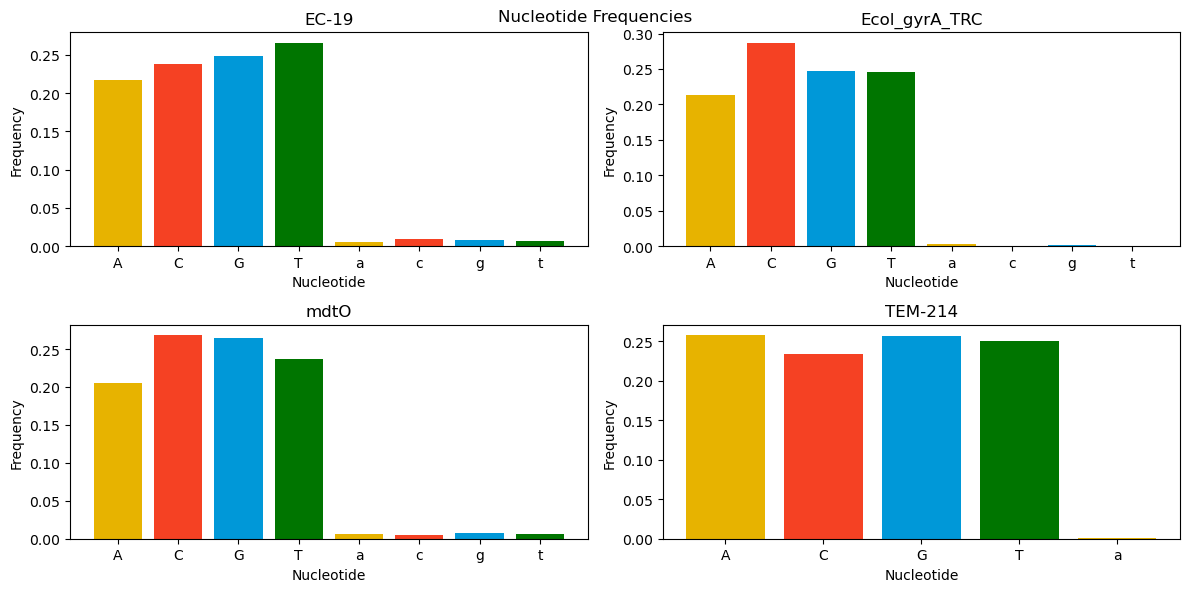

In [20]:
# Function to calculate nucleotide frequency from a sequence
def calculate_nucleotide_frequency(seq):
    freq = Counter(seq)
    total = sum(freq.values())
    return {nucleotide: count / total for nucleotide, count in sorted(freq.items())}

# Sample four random rows from our dataset
random_rows = gene_alignment_df.sample(4, random_state=13)

# Make a 2 by 2 plot and loop through to plot nucleotide counts on each axis
fig, axs = plt.subplots(2, 2, figsize=(12,6))
for ax, gene_row in zip(axs.ravel(), random_rows.itertuples()):
    nucleotide_freq = calculate_nucleotide_frequency(gene_row.ref_gene_str)

    # Bar plot of nucleotide frequencies
    ax.bar(nucleotide_freq.keys(), nucleotide_freq.values(), color=['#e7b300', '#f54123', '#0098d8', '#007500'])
    ax.set_xlabel('Nucleotide')
    ax.set_ylabel('Frequency')
    ax.set_title(gene_row.res_gene.split('|')[-1])
plt.tight_layout()
plt.suptitle("Nucleotide Frequencies");

The differences in nucleotide frequencies across the gene sequences may have implications for understanding their functionality, mutation rates, or evolutionary relationships

Lets recap! 

EDA is a vital part of the data science process and it's worth taking the time to make sure you understand the data you're working with. Hopefully, even in this limited time, you've come away with a few different approaches and techniques you can use when investigating data.

What did we achieve?
1. Loaded and took a look through the raw data
2. Understood which columns we could use
3. Processed our targets and realized how skewed they are
4. Found a few questionable E coli genomes using distributions
5. Started to piece together the relationships between samples and genes
6. Had a look at the raw sequencing data and found some possible mutations

Next steps: Assignment 2 - building on these approaches to review correlations


In [27]:
random_rows.head()

,genome_id,contig,res_gene,match_start,match_end,match_qual,query_str,ref_gene_str
178809,562.45636,SHIL01000048,gb|NG_049084.1|+|100-1234|ARO:3006879|EC-19,4653,5787,1134M,TTACTGTAGAGCGTTGAGAATCTGCCAGGCGGCGGCGAATCTCGCT...,TTACTGTAGAGCGTTGAGAATCTGCCAGGCGGCGGCGAcTCTCGCT...
216007,562.75750,CXZK01000001,gb|U00096.3|-|2336792-2339420|ARO:3004335|Ecol...,356420,359048,2628M,TTATTCTTCTTCTGGCTCGTCGTCAACGTCCACTTCCGGAGCGATT...,TTATTCTTCTTCTGGCTCGTCGTCAACGTCCACTTCCGGAGCGATT...
13654,562.22451,562.22451.con.0011,gb|AP009048.1|-|4304505-4306557|ARO:3003549|mdtO,59787,61839,2052M,ATGAGCGCGCTCAACTCCCTGCCATTACCGGTGGTCAGGCTGCTGG...,ATGAGCGCGCTCAACTCCCTGCCATTACCGGTGGTCAGGCTGCTGG...
90139,562.22876,562.22876.con.0064,gb|KP050491.1|+|0-861|ARO:3001391|TEM-214,3997,4858,861M,ATGAGTATTCAACATTTTCGTGTCGCCCTTTTTCCCTTTTTTGCGG...,ATGAGTATTCAACATTTTCGTGTCGCCCTTaTTCCCTTTTTTGCGG...
